In [1]:
random_seeds4all=[42, 40, 456, 789, 2024]

In [2]:
# 对所有被试分别进行训练（多次不同随机种子）
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from IPython.display import clear_output

# 读取数据
df = pd.read_csv('seleted11_normalized.csv')

# 获取所有被试名单
subjects = df['subject'].unique()
print(f"数据集中共有 {len(subjects)} 个被试: {list(subjects)}\n")

# 设置多个随机种子
random_seeds = random_seeds4all
num_runs = len(random_seeds)
print(f"将使用 {num_runs} 个不同的随机种子进行训练: {random_seeds}")
print("="*80)

# 存储所有被试的结果
all_results = []
detailed_results = []  # 存储每次运行的详细结果

# 对每个被试进行训练
for subject_name in subjects:
    print(f"\n{'='*80}")
    print(f"正在训练被试: {subject_name}")
    print(f"{'='*80}\n")
    
    # 筛选当前被试的数据
    subject_data = df[df['subject'] == subject_name].copy()
    
    print(f"{subject_name} 的数据总数: {len(subject_data)}")
    print(f"\n情绪分布:\n{subject_data['emotion'].value_counts()}\n")
    
    # 准备特征和标签
    X = subject_data[['RMSSD', 'pNN58', 'SDNN', 'SD1', 'SD2', 'SD1_SD2']].values
    y = subject_data['emotion'].values
    
    # 对标签进行编码
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # 存储该被试在不同随机种子下的测试准确率
    test_accuracies_list = []
    train_accuracies_list = []
    
    # 使用不同的随机种子进行多次训练
    for run_idx, seed in enumerate(random_seeds, 1):
        print(f"\n--- 第 {run_idx}/{num_runs} 次训练 (随机种子: {seed}) ---")
        
        # 按8:2划分训练集和测试集
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y_encoded, test_size=0.2, random_state=seed, stratify=y_encoded
            )
        except ValueError as e:
            print(f"⚠️ 数据划分失败: {e}，跳过此次训练")
            continue
        
        print(f"训练集: {len(X_train)}, 测试集: {len(X_test)}")
        
        # 转换为PyTorch张量
        X_train_tensor = torch.FloatTensor(X_train)
        y_train_tensor = torch.LongTensor(y_train)
        X_test_tensor = torch.FloatTensor(X_test)
        y_test_tensor = torch.LongTensor(y_test)
        
        # 定义3层线性神经网络
        class ThreeLayerNN(nn.Module):
            def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
                super(ThreeLayerNN, self).__init__()
                self.fc1 = nn.Linear(input_size, hidden_size1)
                self.relu1 = nn.ReLU()
                self.fc2 = nn.Linear(hidden_size1, hidden_size2)
                self.relu2 = nn.ReLU()
                self.fc3 = nn.Linear(hidden_size2, num_classes)
            
            def forward(self, x):
                out = self.fc1(x)
                out = self.relu1(out)
                out = self.fc2(out)
                out = self.relu2(out)
                out = self.fc3(out)
                return out
        
        # 设置超参数
        input_size = X_train.shape[1]
        hidden_size1 = 64
        hidden_size2 = 32
        num_classes = len(label_encoder.classes_)
        learning_rate = 0.001
        num_epochs = 300
        
        # 设置随机种子以确保可重复性
        torch.manual_seed(seed)
        np.random.seed(seed)
        
        # 创建模型
        model = ThreeLayerNN(input_size, hidden_size1, hidden_size2, num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # 训练模型
        train_losses = []
        train_accuracies = []
        
        for epoch in range(num_epochs):
            # 前向传播
            outputs = model(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # 计算训练准确率
            _, predicted = torch.max(outputs.data, 1)
            total = y_train_tensor.size(0)
            correct = (predicted == y_train_tensor).sum().item()
            accuracy = 100 * correct / total
            
            train_losses.append(loss.item())
            train_accuracies.append(accuracy)
        
        # 在测试集上评估
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_total = y_test_tensor.size(0)
            test_correct = (test_predicted == y_test_tensor).sum().item()
            test_accuracy = 100 * test_correct / test_total
        
        final_train_acc = train_accuracies[-1]
        
        print(f"  训练准确率: {final_train_acc:.2f}%")
        print(f"  测试准确率: {test_accuracy:.2f}% ({test_correct}/{test_total})")
        
        # 保存结果
        test_accuracies_list.append(test_accuracy)
        train_accuracies_list.append(final_train_acc)
        
        # 保存详细结果
        detailed_results.append({
            '被试': subject_name,
            '运行次数': run_idx,
            '随机种子': seed,
            '训练集大小': len(X_train),
            '测试集大小': len(X_test),
            '训练准确率': f"{final_train_acc:.2f}%",
            '测试准确率': f"{test_accuracy:.2f}%",
            '正确预测': f"{test_correct}/{test_total}"
        })
    
    # 如果至少有一次成功的训练
    if len(test_accuracies_list) > 0:
        avg_test_acc = np.mean(test_accuracies_list)
        std_test_acc = np.std(test_accuracies_list)
        avg_train_acc = np.mean(train_accuracies_list)
        
        print(f"\n✅ {subject_name} 训练完成!")
        print(f"📊 平均训练准确率: {avg_train_acc:.2f}% (±{np.std(train_accuracies_list):.2f}%)")
        print(f"📊 平均测试准确率: {avg_test_acc:.2f}% (±{std_test_acc:.2f}%)")
        print(f"📊 测试准确率范围: {min(test_accuracies_list):.2f}% - {max(test_accuracies_list):.2f}%")
        
        # 保存汇总结果
        all_results.append({
            '被试': subject_name,
            '数据总数': len(subject_data),
            '情绪类别数': num_classes,
            '训练次数': len(test_accuracies_list),
            '平均训练准确率': f"{avg_train_acc:.2f}%",
            '平均测试准确率': f"{avg_test_acc:.2f}%",
            '测试准确率标准差': f"{std_test_acc:.2f}%",
            '最低测试准确率': f"{min(test_accuracies_list):.2f}%",
            '最高测试准确率': f"{max(test_accuracies_list):.2f}%"
        })

# 显示所有结果汇总
print(f"\n\n{'='*80}")
print("所有被试训练结果汇总（基于多次随机种子的平均结果）")
print(f"{'='*80}\n")

results_df = pd.DataFrame(all_results)
print(results_df.to_string(index=False))

# 保存汇总结果到CSV
results_df.to_csv('training_results_summary.csv', index=False, encoding='utf-8-sig')
print(f"\n✅ 汇总结果已保存到: training_results_summary.csv")

# 显示详细结果
print(f"\n\n{'='*80}")
print("详细训练结果（每次随机种子）")
print(f"{'='*80}\n")

detailed_df = pd.DataFrame(detailed_results)
print(detailed_df.to_string(index=False))

# 保存详细结果到CSV
detailed_df.to_csv('training_results_detailed.csv', index=False, encoding='utf-8-sig')
print(f"\n✅ 详细结果已保存到: training_results_detailed.csv")

# 计算并显示总体统计
if len(all_results) > 0:
    avg_test_accs = [float(r['平均测试准确率'].rstrip('%')) for r in all_results]
    print(f"\n\n{'='*80}")
    print("总体统计")
    print(f"{'='*80}")
    print(f"参与训练的被试数: {len(all_results)}")
    print(f"所有被试的平均测试准确率: {np.mean(avg_test_accs):.2f}%")
    print(f"测试准确率标准差: {np.std(avg_test_accs):.2f}%")
    print(f"测试准确率范围: {min(avg_test_accs):.2f}% - {max(avg_test_accs):.2f}%")

数据集中共有 11 个被试: ['赵紫涵', '朱燕', '陈盈盈', '邓雯', '朱必艳', '张卜依', '朱颖', '王滋雨', '梁怡', '韩乐蓉', '李佳宜']

将使用 5 个不同的随机种子进行训练: [42, 40, 456, 789, 2024]

正在训练被试: 赵紫涵

赵紫涵 的数据总数: 1080

情绪分布:
emotion
愉悦    545
焦虑    259
平静    182
悲伤     94
Name: count, dtype: int64


--- 第 1/5 次训练 (随机种子: 42) ---
训练集: 864, 测试集: 216
  训练准确率: 54.75%
  测试准确率: 49.07% (106/216)

--- 第 2/5 次训练 (随机种子: 40) ---
训练集: 864, 测试集: 216
  训练准确率: 54.98%
  测试准确率: 46.30% (100/216)

--- 第 3/5 次训练 (随机种子: 456) ---
训练集: 864, 测试集: 216
  训练准确率: 55.44%
  测试准确率: 50.93% (110/216)

--- 第 4/5 次训练 (随机种子: 789) ---
训练集: 864, 测试集: 216
  训练准确率: 55.21%
  测试准确率: 48.15% (104/216)

--- 第 5/5 次训练 (随机种子: 2024) ---
训练集: 864, 测试集: 216
  训练准确率: 54.98%
  测试准确率: 49.54% (107/216)

✅ 赵紫涵 训练完成!
📊 平均训练准确率: 55.07% (±0.24%)
📊 平均测试准确率: 48.80% (±1.54%)
📊 测试准确率范围: 46.30% - 50.93%

正在训练被试: 朱燕

朱燕 的数据总数: 1445

情绪分布:
emotion
愉悦    467
焦虑    427
平静    292
悲伤    259
Name: count, dtype: int64


--- 第 1/5 次训练 (随机种子: 42) ---
训练集: 1156, 测试集: 289
  训练准确率: 41.87%
  测试准确率: 35.99% (104/289


神经网络训练结果可视化

已加载 11 个被试的神经网络训练结果



C:\Users\wzcpu\AppData\Local\Temp\ipykernel_31216\274013510.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(box_data, labels=subjects_list, patch_artist=True)



✅ 可视化图表已保存到: nn_results_visualization.png


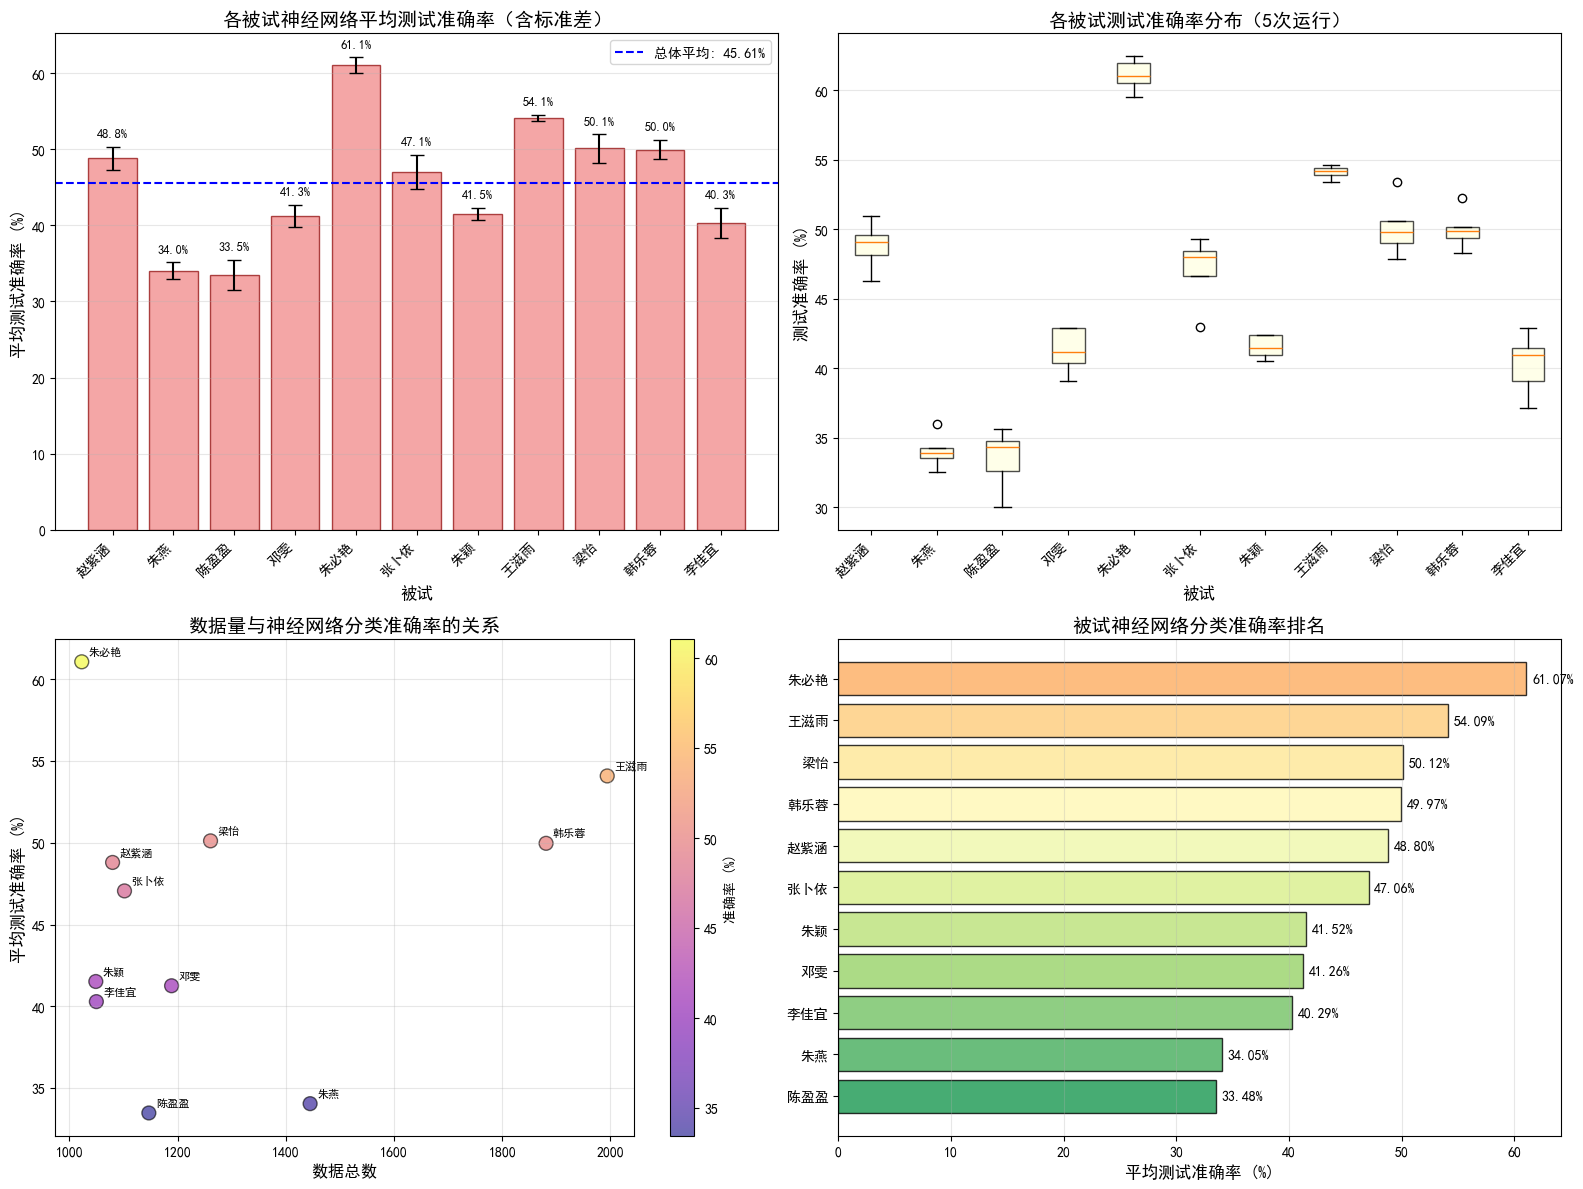


神经网络分类准确率排名
1. 朱必艳: 61.07%
2. 王滋雨: 54.09%
3. 梁怡: 50.12%
4. 韩乐蓉: 49.97%
5. 赵紫涵: 48.80%
6. 张卜依: 47.06%
7. 朱颖: 41.52%
8. 邓雯: 41.26%
9. 李佳宜: 40.29%
10. 朱燕: 34.05%
11. 陈盈盈: 33.48%

神经网络总体统计
参与训练的被试数: 11
平均测试准确率: 45.61%
准确率标准差: 8.02%
准确率范围: 33.48% - 61.07%
平均稳定性标准差: 1.43%

✅ 训练vs测试对比图表已保存到: nn_train_vs_test_comparison.png


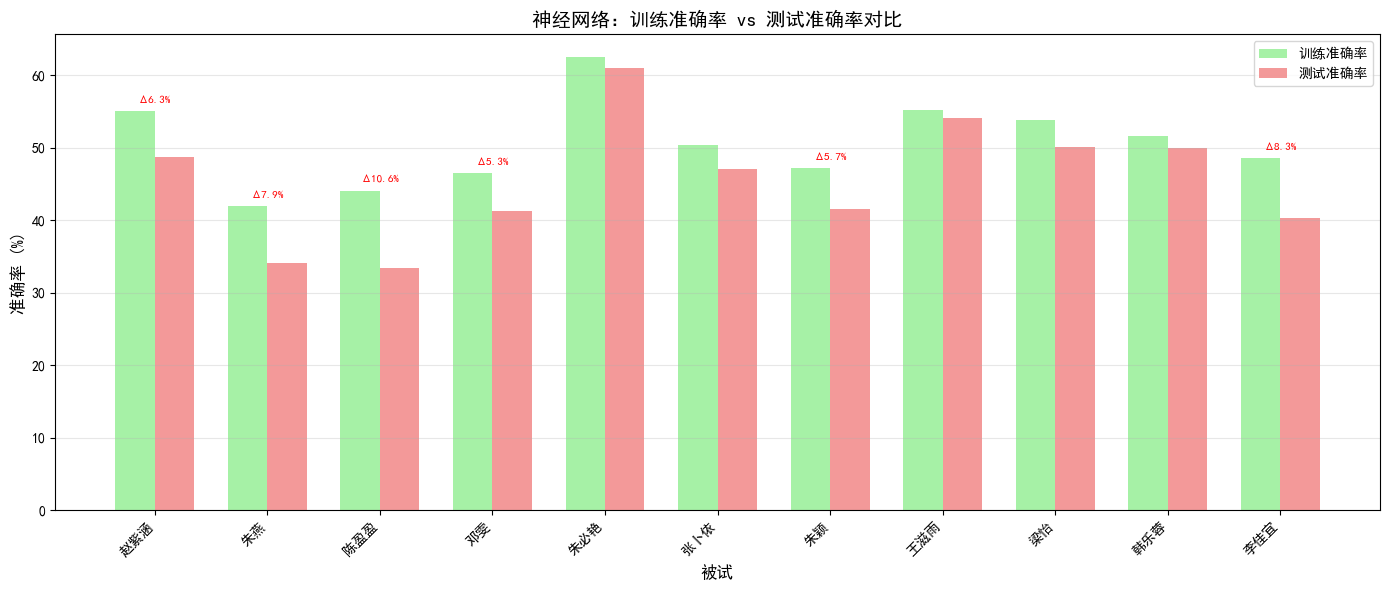

In [3]:
# 可视化神经网络训练结果
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

if os.path.exists('training_results_summary.csv'):
    print(f"\n{'='*80}")
    print("神经网络训练结果可视化")
    print(f"{'='*80}\n")
    
    # 读取神经网络训练结果
    nn_results = pd.read_csv('training_results_summary.csv')
    nn_detailed = pd.read_csv('training_results_detailed.csv')
    
    # 提取数据
    subjects_list = nn_results['被试'].tolist()
    avg_accs = [float(acc.rstrip('%')) for acc in nn_results['平均测试准确率']]
    std_accs = [float(std.rstrip('%')) for std in nn_results['测试准确率标准差']]
    
    print(f"已加载 {len(subjects_list)} 个被试的神经网络训练结果\n")
    
    # 创建图形
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. 每个被试的平均测试准确率柱状图
    ax1 = axes[0, 0]
    bars = ax1.bar(range(len(subjects_list)), avg_accs, yerr=std_accs, 
                    capsize=5, alpha=0.7, color='lightcoral', edgecolor='darkred')
    ax1.set_xlabel('被试', fontsize=12)
    ax1.set_ylabel('平均测试准确率 (%)', fontsize=12)
    ax1.set_title('各被试神经网络平均测试准确率（含标准差）', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(len(subjects_list)))
    ax1.set_xticklabels(subjects_list, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.axhline(y=np.mean(avg_accs), color='blue', linestyle='--', 
                label=f'总体平均: {np.mean(avg_accs):.2f}%')
    ax1.legend()
    
    # 在柱状图上显示数值
    for i, (acc, std) in enumerate(zip(avg_accs, std_accs)):
        ax1.text(i, acc + std + 1, f'{acc:.1f}%', 
                ha='center', va='bottom', fontsize=9)
    
    # 2. 测试准确率的箱线图（展示稳定性）
    ax2 = axes[0, 1]
    
    # 为每个被试收集所有运行的测试准确率
    subject_accuracies = {}
    for _, detail in nn_detailed.iterrows():
        subj = detail['被试']
        acc = float(detail['测试准确率'].rstrip('%'))
        if subj not in subject_accuracies:
            subject_accuracies[subj] = []
        subject_accuracies[subj].append(acc)
    
    box_data = [subject_accuracies[subj] for subj in subjects_list]
    bp = ax2.boxplot(box_data, labels=subjects_list, patch_artist=True)
    
    for patch in bp['boxes']:
        patch.set_facecolor('lightyellow')
        patch.set_alpha(0.7)
    
    ax2.set_xlabel('被试', fontsize=12)
    ax2.set_ylabel('测试准确率 (%)', fontsize=12)
    ax2.set_title('各被试测试准确率分布（5次运行）', fontsize=14, fontweight='bold')
    ax2.set_xticklabels(subjects_list, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. 数据量与准确率的关系
    ax3 = axes[1, 0]
    data_sizes = nn_results['数据总数'].tolist()
    
    scatter = ax3.scatter(data_sizes, avg_accs, s=100, alpha=0.6, 
                         c=avg_accs, cmap='plasma', edgecolors='black')
    
    # 添加被试名称标注
    for i, subj in enumerate(subjects_list):
        ax3.annotate(subj, (data_sizes[i], avg_accs[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax3.set_xlabel('数据总数', fontsize=12)
    ax3.set_ylabel('平均测试准确率 (%)', fontsize=12)
    ax3.set_title('数据量与神经网络分类准确率的关系', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='准确率 (%)')
    
    # 4. 准确率排名
    ax4 = axes[1, 1]
    
    # 按准确率排序
    sorted_indices = np.argsort(avg_accs)[::-1]
    sorted_subjects = [subjects_list[i] for i in sorted_indices]
    sorted_accs = [avg_accs[i] for i in sorted_indices]
    
    colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(sorted_subjects)))
    bars = ax4.barh(range(len(sorted_subjects)), sorted_accs, color=colors, 
                     edgecolor='black', alpha=0.8)
    
    ax4.set_yticks(range(len(sorted_subjects)))
    ax4.set_yticklabels(sorted_subjects)
    ax4.set_xlabel('平均测试准确率 (%)', fontsize=12)
    ax4.set_title('被试神经网络分类准确率排名', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')
    ax4.invert_yaxis()  # 最高的在上面
    
    # 在条形图上显示数值
    for i, acc in enumerate(sorted_accs):
        ax4.text(acc + 0.5, i, f'{acc:.2f}%', 
                va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('nn_results_visualization.png', dpi=300, bbox_inches='tight')
    print("\n✅ 可视化图表已保存到: nn_results_visualization.png")
    plt.show()
    
    # 打印排名信息
    print(f"\n{'='*80}")
    print("神经网络分类准确率排名")
    print(f"{'='*80}")
    for rank, (subj, acc) in enumerate(zip(sorted_subjects, sorted_accs), 1):
        print(f"{rank}. {subj}: {acc:.2f}%")
    
    # 打印总体统计
    print(f"\n{'='*80}")
    print("神经网络总体统计")
    print(f"{'='*80}")
    print(f"参与训练的被试数: {len(subjects_list)}")
    print(f"平均测试准确率: {np.mean(avg_accs):.2f}%")
    print(f"准确率标准差: {np.std(avg_accs):.2f}%")
    print(f"准确率范围: {min(avg_accs):.2f}% - {max(avg_accs):.2f}%")
    print(f"平均稳定性标准差: {np.mean(std_accs):.2f}%")
    
    # 额外：训练准确率 vs 测试准确率对比
    fig2, ax = plt.subplots(1, 1, figsize=(14, 6))
    
    train_accs = [float(acc.rstrip('%')) for acc in nn_results['平均训练准确率']]
    x = np.arange(len(subjects_list))
    width = 0.35
    
    ax.bar(x - width/2, train_accs, width, label='训练准确率', alpha=0.8, color='lightgreen')
    ax.bar(x + width/2, avg_accs, width, label='测试准确率', alpha=0.8, color='lightcoral')
    
    ax.set_xlabel('被试', fontsize=12)
    ax.set_ylabel('准确率 (%)', fontsize=12)
    ax.set_title('神经网络：训练准确率 vs 测试准确率对比', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(subjects_list, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 显示过拟合程度（训练-测试差距）
    for i, (train, test) in enumerate(zip(train_accs, avg_accs)):
        diff = train - test
        if diff > 5:  # 差距大于5%标注出来
            ax.text(i, max(train, test) + 1, f'Δ{diff:.1f}%', 
                   ha='center', va='bottom', fontsize=8, color='red')
    
    plt.tight_layout()
    plt.savefig('nn_train_vs_test_comparison.png', dpi=300, bbox_inches='tight')
    print("\n✅ 训练vs测试对比图表已保存到: nn_train_vs_test_comparison.png")
    plt.show()
    
else:
    print("\n⚠️ 未找到神经网络训练结果文件 (training_results_summary.csv)")
    print("请先运行神经网络训练代码生成结果文件")

In [4]:
# 使用SVM对所有被试分别进行训练（多次不同随机种子）
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
df = pd.read_csv('seleted11_normalized.csv')

# 获取所有被试名单
subjects = df['subject'].unique()
print(f"数据集中共有 {len(subjects)} 个被试: {list(subjects)}\n")

# 设置多个随机种子
random_seeds = random_seeds4all
num_runs = len(random_seeds)
print(f"将使用 {num_runs} 个不同的随机种子进行训练: {random_seeds}")
print("="*80)

# 存储所有被试的结果
all_results = []
detailed_results = []  # 存储每次运行的详细结果

# 对每个被试进行训练
for subject_name in subjects:
    print(f"\n{'='*80}")
    print(f"正在训练被试: {subject_name}")
    print(f"{'='*80}\n")
    
    # 筛选当前被试的数据
    subject_data = df[df['subject'] == subject_name].copy()
    
    print(f"{subject_name} 的数据总数: {len(subject_data)}")
    print(f"\n情绪分布:\n{subject_data['emotion'].value_counts()}\n")
    
    # 准备特征和标签
    X = subject_data[['RMSSD', 'pNN58', 'SDNN', 'SD1', 'SD2', 'SD1_SD2']].values
    y = subject_data['emotion'].values
    
    # 对标签进行编码
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # 检查类别数量，如果类别少于2个则跳过
    if len(label_encoder.classes_) < 2:
        print(f"⚠️ {subject_name} 的情绪类别少于2个，跳过训练\n")
        continue
    
    # 存储该被试在不同随机种子下的测试准确率
    test_accuracies_list = []
    train_accuracies_list = []
    
    # 使用不同的随机种子进行多次训练
    for run_idx, seed in enumerate(random_seeds, 1):
        print(f"\n--- 第 {run_idx}/{num_runs} 次训练 (随机种子: {seed}) ---")
        
        # 按8:2划分训练集和测试集
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y_encoded, test_size=0.2, random_state=seed, stratify=y_encoded
            )
        except ValueError as e:
            print(f"⚠️ 数据划分失败: {e}，跳过此次训练")
            continue
        
        print(f"训练集: {len(X_train)}, 测试集: {len(X_test)}")
        
        # 数据标准化（SVM对特征尺度敏感）
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # 创建SVM模型（使用RBF核）
        svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=seed)
        
        # 训练模型
        svm_model.fit(X_train_scaled, y_train)
        
        # 在训练集上评估
        train_pred = svm_model.predict(X_train_scaled)
        train_accuracy = accuracy_score(y_train, train_pred) * 100
        
        # 在测试集上评估
        test_pred = svm_model.predict(X_test_scaled)
        test_accuracy = accuracy_score(y_test, test_pred) * 100
        test_correct = np.sum(test_pred == y_test)
        test_total = len(y_test)
        
        print(f"  训练准确率: {train_accuracy:.2f}%")
        print(f"  测试准确率: {test_accuracy:.2f}% ({test_correct}/{test_total})")
        
        # 保存结果
        test_accuracies_list.append(test_accuracy)
        train_accuracies_list.append(train_accuracy)
        
        # 保存详细结果
        detailed_results.append({
            '被试': subject_name,
            '运行次数': run_idx,
            '随机种子': seed,
            '训练集大小': len(X_train),
            '测试集大小': len(X_test),
            '训练准确率': f"{train_accuracy:.2f}%",
            '测试准确率': f"{test_accuracy:.2f}%",
            '正确预测': f"{test_correct}/{test_total}"
        })
    
    # 如果至少有一次成功的训练
    if len(test_accuracies_list) > 0:
        avg_test_acc = np.mean(test_accuracies_list)
        std_test_acc = np.std(test_accuracies_list)
        avg_train_acc = np.mean(train_accuracies_list)
        
        print(f"\n✅ {subject_name} 训练完成!")
        print(f"📊 平均训练准确率: {avg_train_acc:.2f}% (±{np.std(train_accuracies_list):.2f}%)")
        print(f"📊 平均测试准确率: {avg_test_acc:.2f}% (±{std_test_acc:.2f}%)")
        print(f"📊 测试准确率范围: {min(test_accuracies_list):.2f}% - {max(test_accuracies_list):.2f}%")
        
        # 保存汇总结果
        all_results.append({
            '被试': subject_name,
            '数据总数': len(subject_data),
            '情绪类别数': len(label_encoder.classes_),
            '训练次数': len(test_accuracies_list),
            '平均训练准确率': f"{avg_train_acc:.2f}%",
            '平均测试准确率': f"{avg_test_acc:.2f}%",
            '测试准确率标准差': f"{std_test_acc:.2f}%",
            '最低测试准确率': f"{min(test_accuracies_list):.2f}%",
            '最高测试准确率': f"{max(test_accuracies_list):.2f}%"
        })

# 显示所有结果汇总
print(f"\n\n{'='*80}")
print("所有被试SVM训练结果汇总（基于多次随机种子的平均结果）")
print(f"{'='*80}\n")

results_df = pd.DataFrame(all_results)
print(results_df.to_string(index=False))

# 保存汇总结果到CSV
results_df.to_csv('svm_training_results_summary.csv', index=False, encoding='utf-8-sig')
print(f"\n✅ 汇总结果已保存到: svm_training_results_summary.csv")

# 显示详细结果
print(f"\n\n{'='*80}")
print("详细SVM训练结果（每次随机种子）")
print(f"{'='*80}\n")

detailed_df = pd.DataFrame(detailed_results)
print(detailed_df.to_string(index=False))

# 保存详细结果到CSV
detailed_df.to_csv('svm_training_results_detailed.csv', index=False, encoding='utf-8-sig')
print(f"\n✅ 详细结果已保存到: svm_training_results_detailed.csv")

# 计算并显示总体统计
if len(all_results) > 0:
    avg_test_accs = [float(r['平均测试准确率'].rstrip('%')) for r in all_results]
    print(f"\n\n{'='*80}")
    print("总体统计")
    print(f"{'='*80}")
    print(f"参与训练的被试数: {len(all_results)}")
    print(f"所有被试的平均测试准确率: {np.mean(avg_test_accs):.2f}%")
    print(f"测试准确率标准差: {np.std(avg_test_accs):.2f}%")
    print(f"测试准确率范围: {min(avg_test_accs):.2f}% - {max(avg_test_accs):.2f}%")

数据集中共有 11 个被试: ['赵紫涵', '朱燕', '陈盈盈', '邓雯', '朱必艳', '张卜依', '朱颖', '王滋雨', '梁怡', '韩乐蓉', '李佳宜']

将使用 5 个不同的随机种子进行训练: [42, 40, 456, 789, 2024]

正在训练被试: 赵紫涵

赵紫涵 的数据总数: 1080

情绪分布:
emotion
愉悦    545
焦虑    259
平静    182
悲伤     94
Name: count, dtype: int64


--- 第 1/5 次训练 (随机种子: 42) ---
训练集: 864, 测试集: 216
  训练准确率: 52.66%
  测试准确率: 52.78% (114/216)

--- 第 2/5 次训练 (随机种子: 40) ---
训练集: 864, 测试集: 216
  训练准确率: 53.70%
  测试准确率: 47.69% (103/216)

--- 第 3/5 次训练 (随机种子: 456) ---
训练集: 864, 测试集: 216
  训练准确率: 53.82%
  测试准确率: 50.93% (110/216)

--- 第 4/5 次训练 (随机种子: 789) ---
训练集: 864, 测试集: 216
  训练准确率: 53.47%
  测试准确率: 50.93% (110/216)

--- 第 5/5 次训练 (随机种子: 2024) ---
训练集: 864, 测试集: 216
  训练准确率: 53.94%
  测试准确率: 51.39% (111/216)

✅ 赵紫涵 训练完成!
📊 平均训练准确率: 53.52% (±0.45%)
📊 平均测试准确率: 50.74% (±1.67%)
📊 测试准确率范围: 47.69% - 52.78%

正在训练被试: 朱燕

朱燕 的数据总数: 1445

情绪分布:
emotion
愉悦    467
焦虑    427
平静    292
悲伤    259
Name: count, dtype: int64


--- 第 1/5 次训练 (随机种子: 42) ---
训练集: 1156, 测试集: 289
  训练准确率: 39.71%
  测试准确率: 35.64% (103/289

C:\Users\wzcpu\AppData\Local\Temp\ipykernel_31216\1867735719.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(box_data, labels=subjects_list, patch_artist=True)



✅ 可视化图表已保存到: svm_results_visualization.png


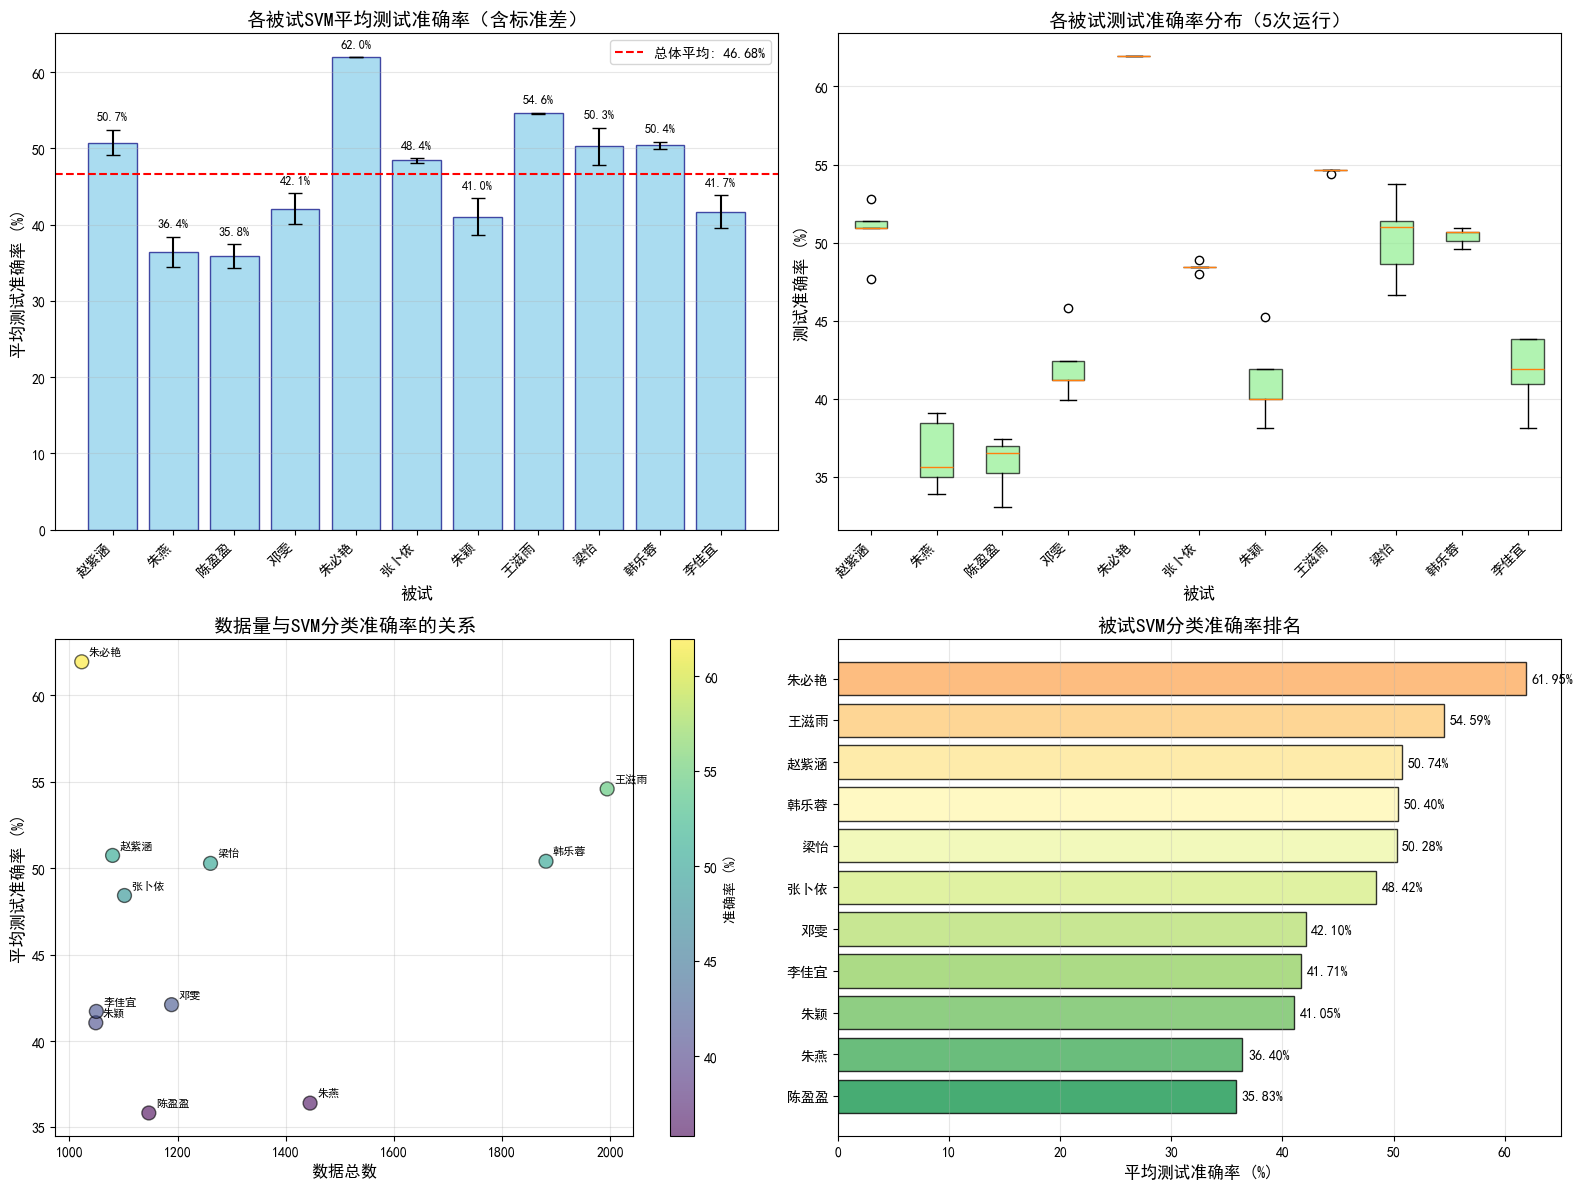


SVM分类准确率排名
1. 朱必艳: 61.95%
2. 王滋雨: 54.59%
3. 赵紫涵: 50.74%
4. 韩乐蓉: 50.40%
5. 梁怡: 50.28%
6. 张卜依: 48.42%
7. 邓雯: 42.10%
8. 李佳宜: 41.71%
9. 朱颖: 41.05%
10. 朱燕: 36.40%
11. 陈盈盈: 35.83%


In [5]:
# 可视化SVM分类结果
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

if len(all_results) > 0:
    # 创建图形
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. 每个被试的平均测试准确率柱状图
    subjects_list = [r['被试'] for r in all_results]
    avg_accs = [float(r['平均测试准确率'].rstrip('%')) for r in all_results]
    std_accs = [float(r['测试准确率标准差'].rstrip('%')) for r in all_results]
    
    ax1 = axes[0, 0]
    bars = ax1.bar(range(len(subjects_list)), avg_accs, yerr=std_accs, 
                    capsize=5, alpha=0.7, color='skyblue', edgecolor='navy')
    ax1.set_xlabel('被试', fontsize=12)
    ax1.set_ylabel('平均测试准确率 (%)', fontsize=12)
    ax1.set_title('各被试SVM平均测试准确率（含标准差）', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(len(subjects_list)))
    ax1.set_xticklabels(subjects_list, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.axhline(y=np.mean(avg_accs), color='red', linestyle='--', 
                label=f'总体平均: {np.mean(avg_accs):.2f}%')
    ax1.legend()
    
    # 在柱状图上显示数值
    for i, (acc, std) in enumerate(zip(avg_accs, std_accs)):
        ax1.text(i, acc + std + 1, f'{acc:.1f}%', 
                ha='center', va='bottom', fontsize=9)
    
    # 2. 测试准确率的箱线图（展示稳定性）
    ax2 = axes[0, 1]
    
    # 为每个被试收集所有运行的测试准确率
    subject_accuracies = {}
    for detail in detailed_results:
        subj = detail['被试']
        acc = float(detail['测试准确率'].rstrip('%'))
        if subj not in subject_accuracies:
            subject_accuracies[subj] = []
        subject_accuracies[subj].append(acc)
    
    box_data = [subject_accuracies[subj] for subj in subjects_list]
    bp = ax2.boxplot(box_data, labels=subjects_list, patch_artist=True)
    
    for patch in bp['boxes']:
        patch.set_facecolor('lightgreen')
        patch.set_alpha(0.7)
    
    ax2.set_xlabel('被试', fontsize=12)
    ax2.set_ylabel('测试准确率 (%)', fontsize=12)
    ax2.set_title('各被试测试准确率分布（5次运行）', fontsize=14, fontweight='bold')
    ax2.set_xticklabels(subjects_list, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. 数据量与准确率的关系
    ax3 = axes[1, 0]
    data_sizes = [r['数据总数'] for r in all_results]
    
    scatter = ax3.scatter(data_sizes, avg_accs, s=100, alpha=0.6, 
                         c=avg_accs, cmap='viridis', edgecolors='black')
    
    # 添加被试名称标注
    for i, subj in enumerate(subjects_list):
        ax3.annotate(subj, (data_sizes[i], avg_accs[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax3.set_xlabel('数据总数', fontsize=12)
    ax3.set_ylabel('平均测试准确率 (%)', fontsize=12)
    ax3.set_title('数据量与SVM分类准确率的关系', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='准确率 (%)')
    
    # 4. 准确率排名
    ax4 = axes[1, 1]
    
    # 按准确率排序
    sorted_indices = np.argsort(avg_accs)[::-1]
    sorted_subjects = [subjects_list[i] for i in sorted_indices]
    sorted_accs = [avg_accs[i] for i in sorted_indices]
    
    colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(sorted_subjects)))
    bars = ax4.barh(range(len(sorted_subjects)), sorted_accs, color=colors, 
                     edgecolor='black', alpha=0.8)
    
    ax4.set_yticks(range(len(sorted_subjects)))
    ax4.set_yticklabels(sorted_subjects)
    ax4.set_xlabel('平均测试准确率 (%)', fontsize=12)
    ax4.set_title('被试SVM分类准确率排名', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')
    ax4.invert_yaxis()  # 最高的在上面
    
    # 在条形图上显示数值
    for i, acc in enumerate(sorted_accs):
        ax4.text(acc + 0.5, i, f'{acc:.2f}%', 
                va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('svm_results_visualization.png', dpi=300, bbox_inches='tight')
    print("\n✅ 可视化图表已保存到: svm_results_visualization.png")
    plt.show()
    
    # 打印排名信息
    print(f"\n{'='*80}")
    print("SVM分类准确率排名")
    print(f"{'='*80}")
    for rank, (subj, acc) in enumerate(zip(sorted_subjects, sorted_accs), 1):
        print(f"{rank}. {subj}: {acc:.2f}%")
else:
    print("没有可用的结果数据进行可视化")


SVM vs 神经网络性能对比

 被试 SVM准确率 神经网络准确率     差异 更好的模型
赵紫涵 50.74%  48.80% +1.94%   SVM
 朱燕 36.40%  34.05% +2.35%   SVM
陈盈盈 35.83%  33.48% +2.35%   SVM
 邓雯 42.10%  41.26% +0.84%   SVM
朱必艳 61.95%  61.07% +0.88%   SVM
张卜依 48.42%  47.06% +1.36%   SVM
 朱颖 41.05%  41.52% -0.47%  神经网络
王滋雨 54.59%  54.09% +0.50%   SVM
 梁怡 50.28%  50.12% +0.16%   SVM
韩乐蓉 50.40%  49.97% +0.43%   SVM
李佳宜 41.71%  40.29% +1.42%   SVM

✅ 对比结果已保存到: svm_vs_nn_comparison.csv

总体对比统计
SVM表现更好的被试数: 10
神经网络表现更好的被试数: 1
表现相同的被试数: 0

SVM平均准确率: 46.68%
神经网络平均准确率: 45.61%
平均差异: +1.07%

✅ 对比可视化图表已保存到: svm_vs_nn_comparison.png


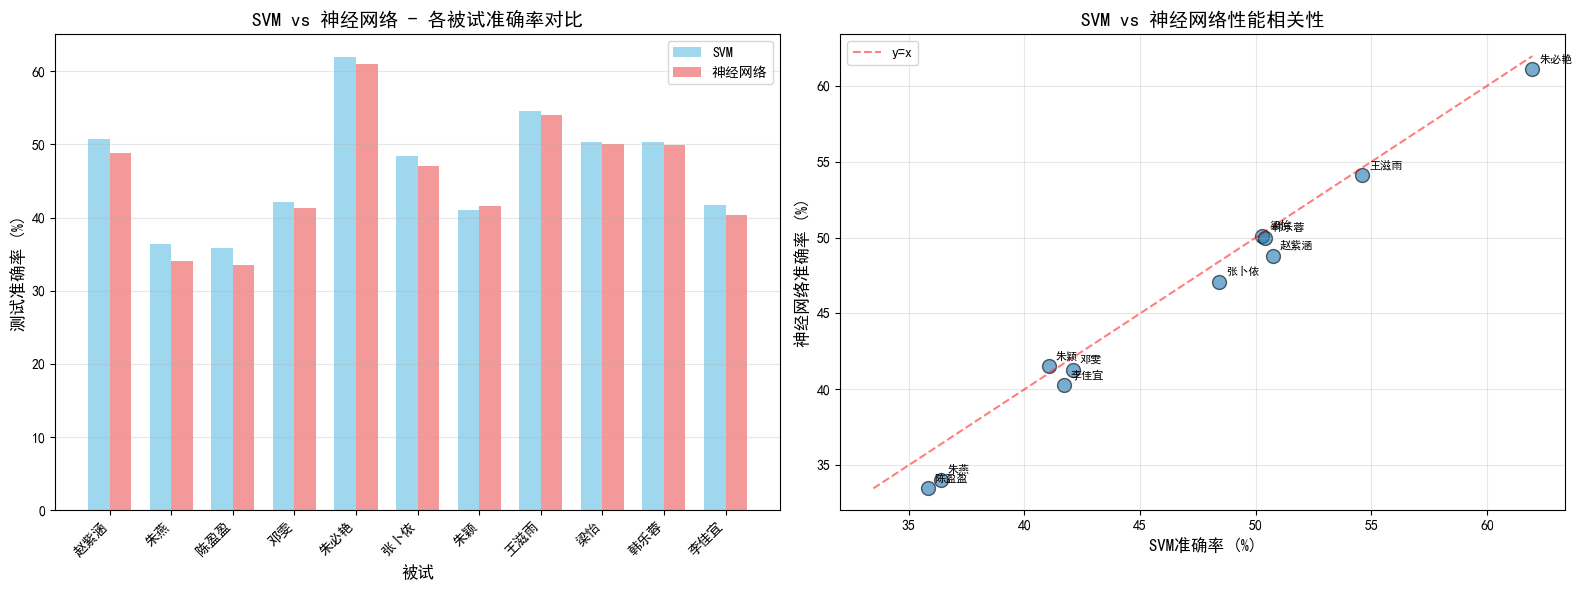

In [6]:
# 对比SVM与神经网络的结果（如果神经网络结果文件存在）
import os

if os.path.exists('training_results_summary.csv'):
    print(f"\n{'='*80}")
    print("SVM vs 神经网络性能对比")
    print(f"{'='*80}\n")
    
    # 读取神经网络结果
    nn_results = pd.read_csv('training_results_summary.csv')
    svm_results = results_df
    
    # 合并结果进行对比
    comparison = []
    
    for _, svm_row in svm_results.iterrows():
        subject = svm_row['被试']
        nn_row = nn_results[nn_results['被试'] == subject]
        
        if not nn_row.empty:
            svm_acc = float(svm_row['平均测试准确率'].rstrip('%'))
            nn_acc = float(nn_row.iloc[0]['平均测试准确率'].rstrip('%'))
            
            comparison.append({
                '被试': subject,
                'SVM准确率': f"{svm_acc:.2f}%",
                '神经网络准确率': f"{nn_acc:.2f}%",
                '差异': f"{svm_acc - nn_acc:+.2f}%",
                '更好的模型': 'SVM' if svm_acc > nn_acc else ('神经网络' if nn_acc > svm_acc else '相同')
            })
    
    if len(comparison) > 0:
        comparison_df = pd.DataFrame(comparison)
        print(comparison_df.to_string(index=False))
        
        # 保存对比结果
        comparison_df.to_csv('svm_vs_nn_comparison.csv', index=False, encoding='utf-8-sig')
        print(f"\n✅ 对比结果已保存到: svm_vs_nn_comparison.csv")
        
        # 统计哪个模型更好
        svm_wins = sum(1 for c in comparison if c['更好的模型'] == 'SVM')
        nn_wins = sum(1 for c in comparison if c['更好的模型'] == '神经网络')
        ties = sum(1 for c in comparison if c['更好的模型'] == '相同')
        
        print(f"\n{'='*80}")
        print("总体对比统计")
        print(f"{'='*80}")
        print(f"SVM表现更好的被试数: {svm_wins}")
        print(f"神经网络表现更好的被试数: {nn_wins}")
        print(f"表现相同的被试数: {ties}")
        
        # 计算平均准确率
        svm_accs = [float(c['SVM准确率'].rstrip('%')) for c in comparison]
        nn_accs = [float(c['神经网络准确率'].rstrip('%')) for c in comparison]
        
        print(f"\nSVM平均准确率: {np.mean(svm_accs):.2f}%")
        print(f"神经网络平均准确率: {np.mean(nn_accs):.2f}%")
        print(f"平均差异: {np.mean(svm_accs) - np.mean(nn_accs):+.2f}%")
        
        # 可视化对比
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # 对比柱状图
        ax1 = axes[0]
        x = np.arange(len(comparison))
        width = 0.35
        
        ax1.bar(x - width/2, svm_accs, width, label='SVM', alpha=0.8, color='skyblue')
        ax1.bar(x + width/2, nn_accs, width, label='神经网络', alpha=0.8, color='lightcoral')
        
        ax1.set_xlabel('被试', fontsize=12)
        ax1.set_ylabel('测试准确率 (%)', fontsize=12)
        ax1.set_title('SVM vs 神经网络 - 各被试准确率对比', fontsize=14, fontweight='bold')
        ax1.set_xticks(x)
        ax1.set_xticklabels([c['被试'] for c in comparison], rotation=45, ha='right')
        ax1.legend()
        ax1.grid(True, alpha=0.3, axis='y')
        
        # 散点图（相关性）
        ax2 = axes[1]
        ax2.scatter(svm_accs, nn_accs, s=100, alpha=0.6, edgecolors='black')
        
        # 添加对角线（表示相同性能）
        min_acc = min(min(svm_accs), min(nn_accs))
        max_acc = max(max(svm_accs), max(nn_accs))
        ax2.plot([min_acc, max_acc], [min_acc, max_acc], 'r--', alpha=0.5, label='y=x')
        
        # 添加被试标注
        for i, comp in enumerate(comparison):
            ax2.annotate(comp['被试'], (svm_accs[i], nn_accs[i]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        ax2.set_xlabel('SVM准确率 (%)', fontsize=12)
        ax2.set_ylabel('神经网络准确率 (%)', fontsize=12)
        ax2.set_title('SVM vs 神经网络性能相关性', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('svm_vs_nn_comparison.png', dpi=300, bbox_inches='tight')
        print("\n✅ 对比可视化图表已保存到: svm_vs_nn_comparison.png")
        plt.show()
    else:
        print("没有找到匹配的被试进行对比")
else:
    print("\n未找到神经网络训练结果文件 (training_results_summary.csv)")
    print("请先运行 linearmodel.ipynb 中的训练代码")